# Tutorial

### Setting up environment

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from skimage.io import imread, imshow
import seaborn as sns
import cv2
from glob import glob
import pandas as pd
import json
import os
import numpy as np
import os
import torch
import numpy as np
from ELD.utils import (toImg, preprocess, predict_landmarks, create_target_landmarks, 
                       create_target_images, download_images_urls, downscale_images, plot_images, 
                       mask_background, padImg, crop_non_tissue, downsize_and_save, 
                       rescale_landmarks, pad_image_and_adjust_landmarks, corr,plot_warped_images)
from ELD.model import loadFan, crop, toGrey
from ELD.warp import Homo, Rigid, TPS

### Downloading data

In [3]:
urlList = [
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep1.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep2.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep3.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep4.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep5_MOB.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep7_MOB.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep8_MOB.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep9_MOB.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep10_MOB.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep11_MOB.jpg",
    "https://9b0ce2.p3cdn1.secureserver.net/wp-content/uploads/2016/07/HE_Rep12_MOB.jpg"
]
imageList = download_images_urls(urlList)

### Downscale the data

In [4]:
imageList = downscale_images(imageList)

### Make sure the data have the same flip

In [5]:
for i, image in enumerate(imageList):
    if i in [0,8,9,10]:
        image = np.flip(image)
        
    if i in [1,3,4]:
        image = np.rot90(image,1)
        image = np.flip(image)
        
    imageList[i] = image

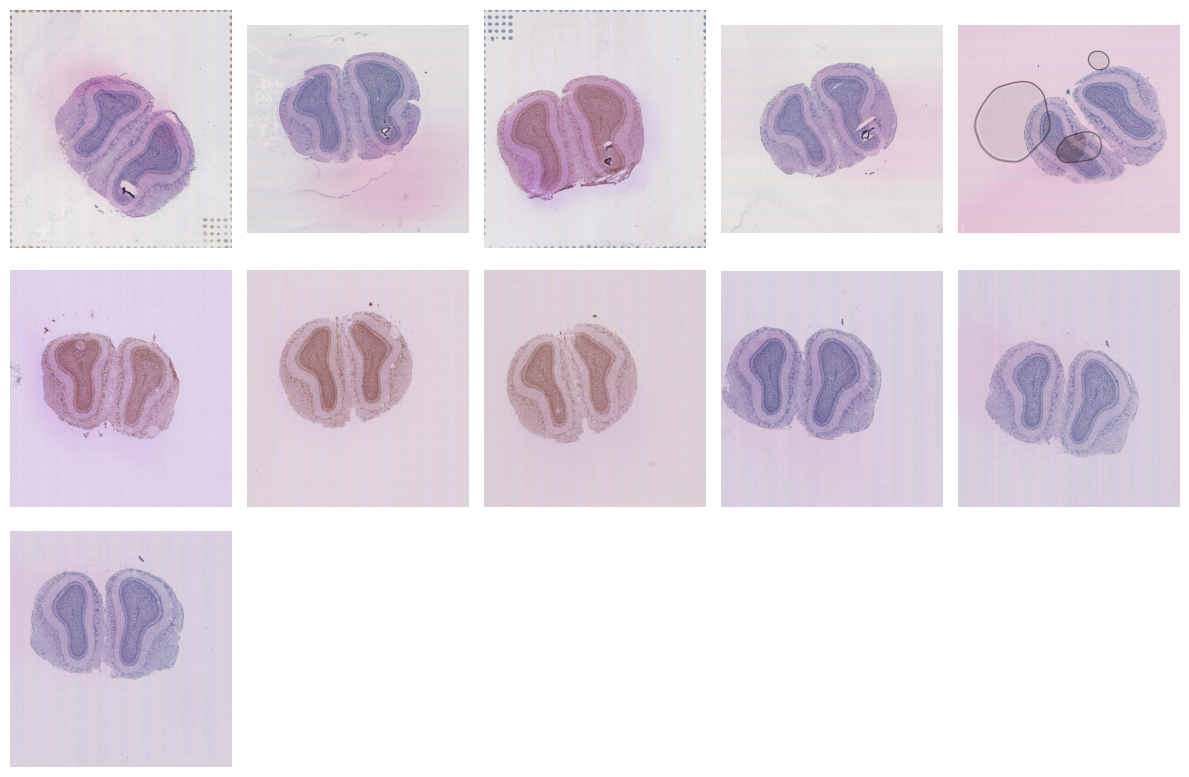

In [6]:
plot_images(imageList)

### Mask background

In [7]:
imageList = mask_background(imageList)

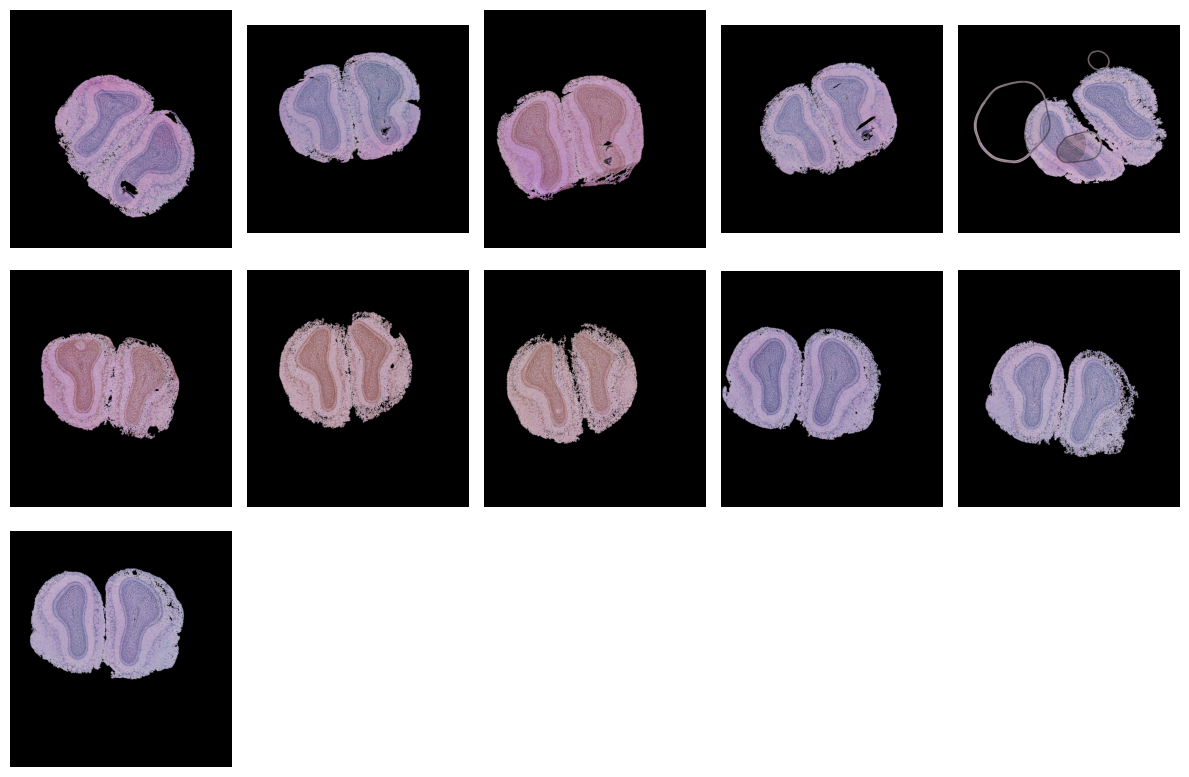

In [8]:
plot_images(imageList)

### Crop non-tissue regions

In [9]:
imageList = crop_non_tissue(imageList)

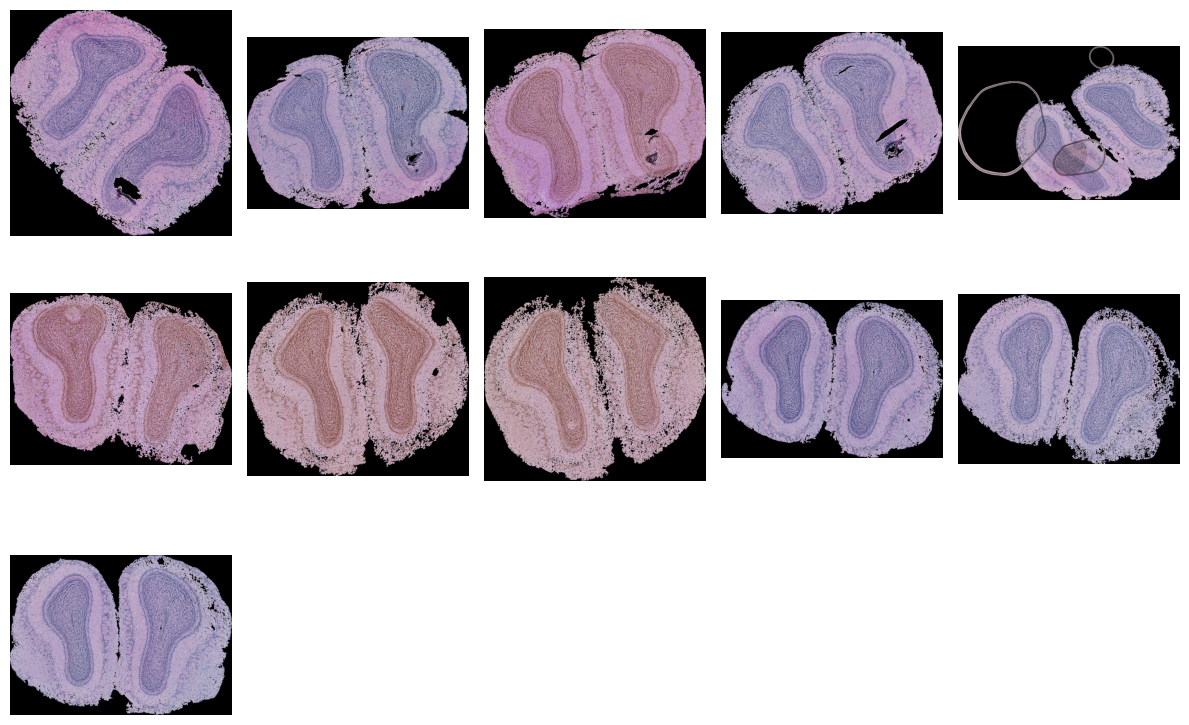

In [10]:
plot_images(imageList)

### Resize images to 128x128 and save it for training

In [11]:
small_imgs = downsize_and_save(imageList, "/data/ekvall/tutorial/")


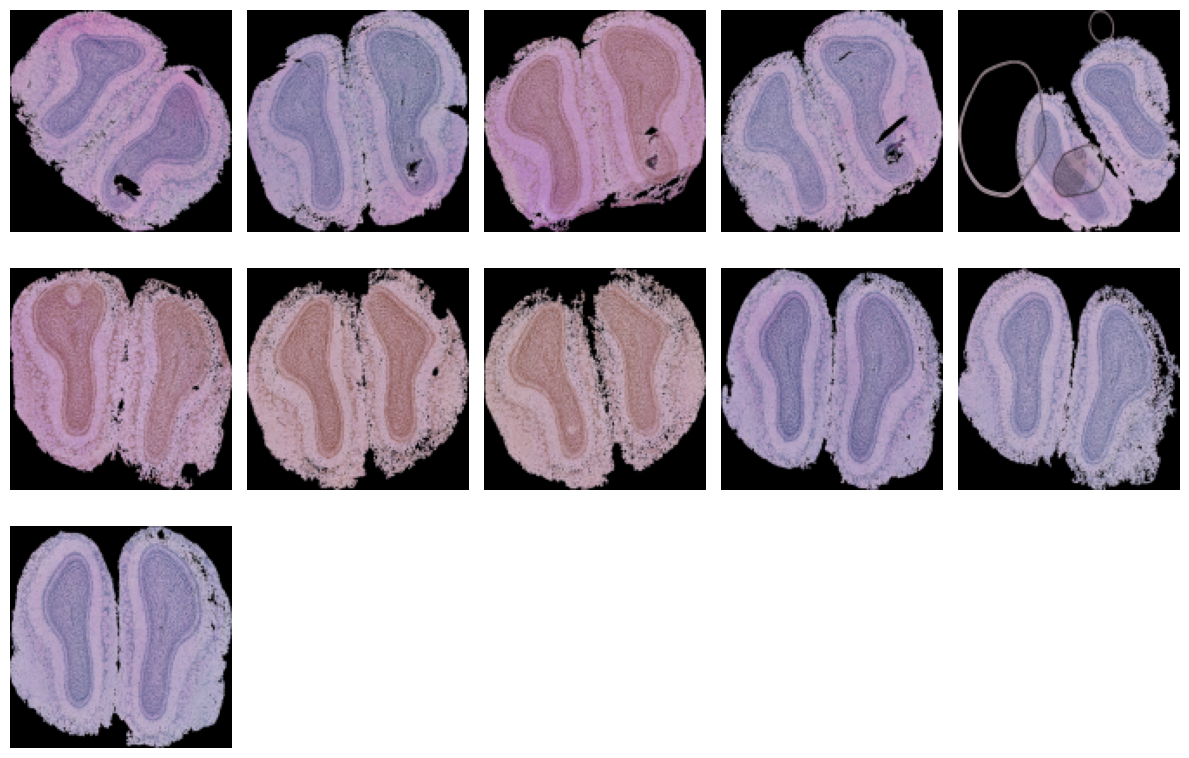

In [12]:
plot_images(small_imgs)

### Train model

```
python -m visdom.server -port 9006

eld-train --elastic_sigma 5 --cuda 1 --port 9006 --data_path /data/ekvall/tutorial/ --npts 14 --o scratch --step_size 5 --ws 0 --gamma 0.9 --angle 8 --model unimodal
```

### Preprocess images into torch tensors

In [13]:
image = torch.stack([preprocess(img) for img in small_imgs])

### Load model and predict landmarks

In [14]:
fan = loadFan(npoints=14,n_channels=3,path_to_model="../Exp_2/model_158.fan.pth")
#predict landmarks
pts = predict_landmarks(fan, image)

### Show landmarks

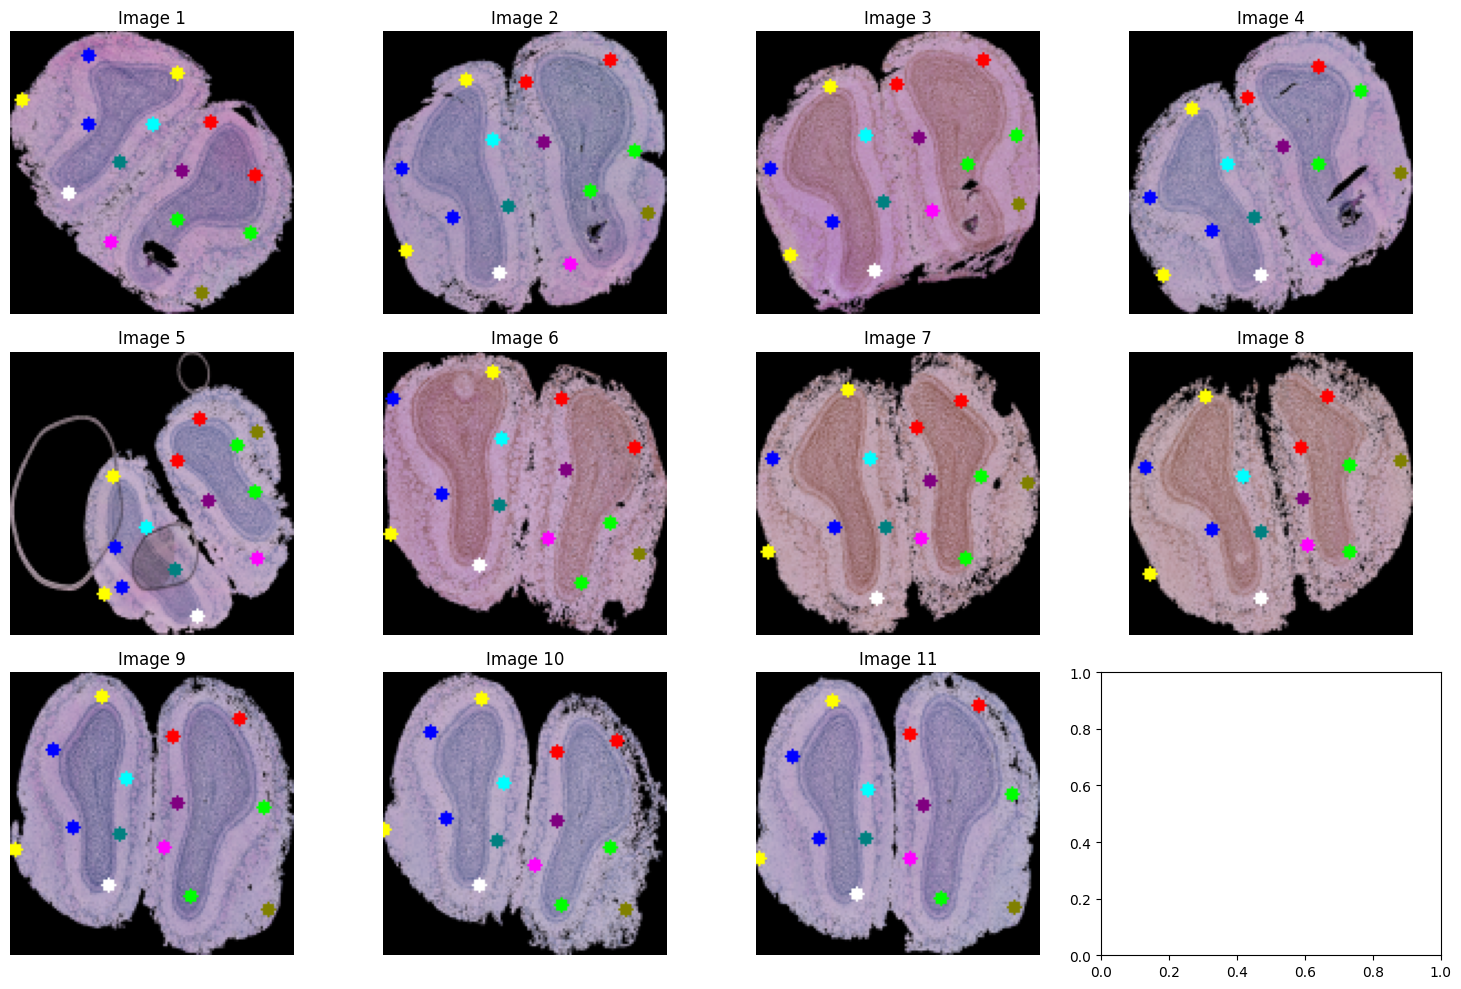

In [15]:
#combine landmarks and image
np_img = toImg(image.cuda()[:,:3], pts, 128)


fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # adjust the size as needed
axs = axs.ravel()

for i in range(len(np_img)):
    img = np_img[i]
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')  # to hide the axis

plt.tight_layout()
plt.show()

### Scale back landmarks to original images

In [16]:


scaled_pts = rescale_landmarks(pts, imageList)

### Zero pad all images so they have the same size

In [17]:
padded_images_torch, adjusted_landmarks = pad_image_and_adjust_landmarks(imageList, scaled_pts)

### Plot original shaped images with their landmarks

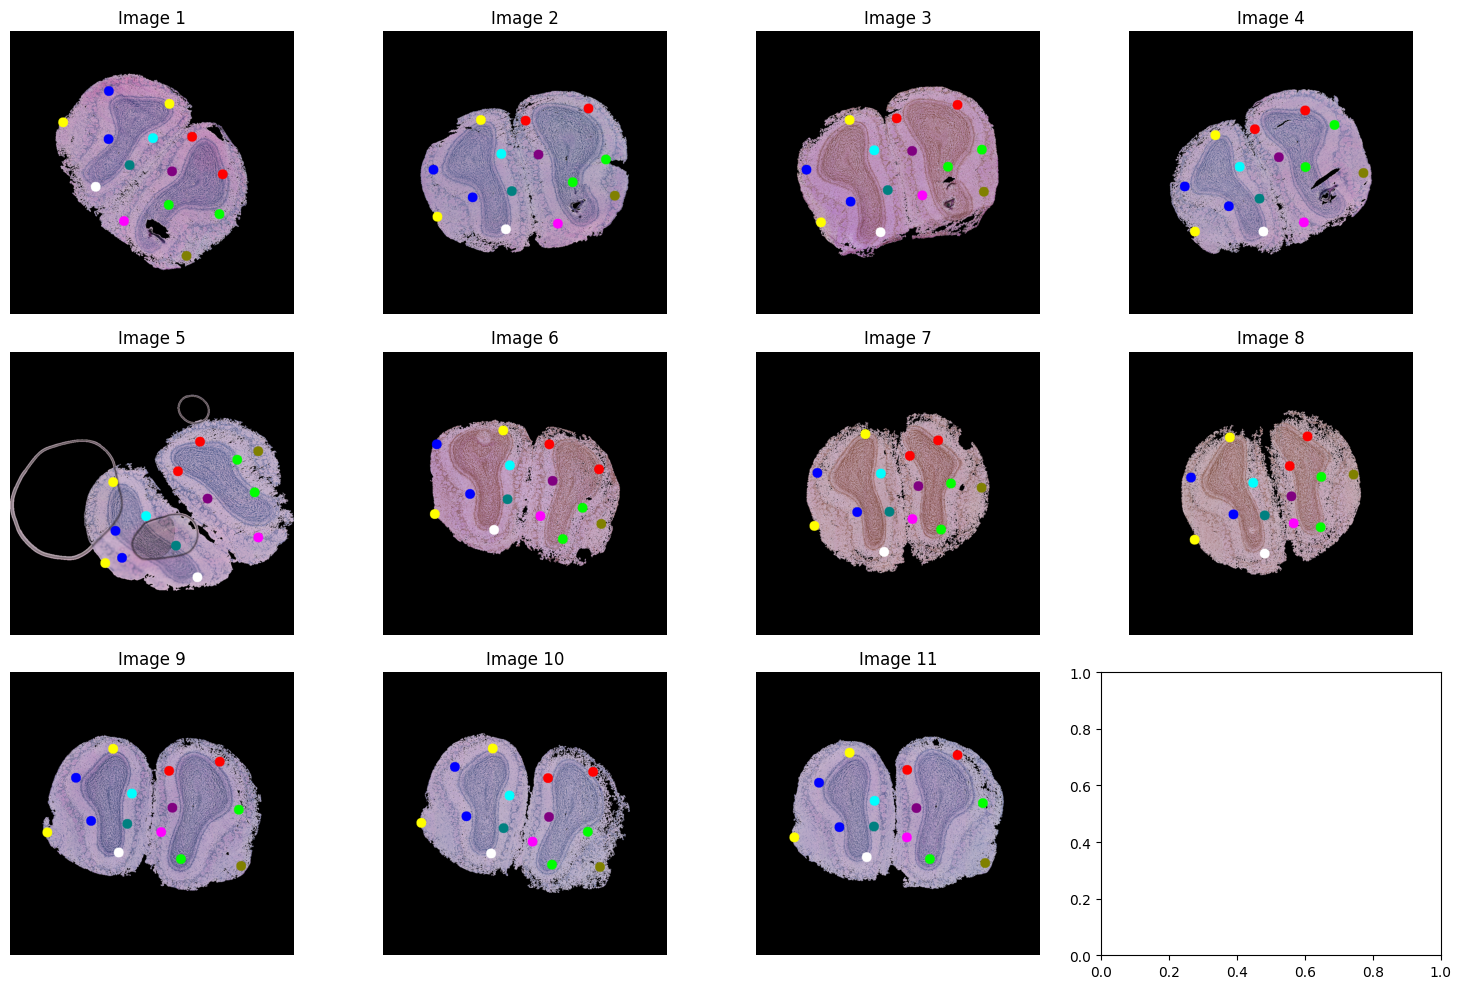

In [18]:
np_img = toImg(padded_images_torch.cuda()[:,:3], adjusted_landmarks, 5 * 128)

fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # adjust the size as needed
axs = axs.ravel()

for i in range(len(np_img)):
    img = np_img[i]
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')  # to hide the axis

plt.tight_layout()
plt.show()

### Create desition image for registration

In [19]:
image = padded_images_torch
dst_image = create_target_images(image, 0)

pts = adjusted_landmarks
dst_pts = create_target_landmarks(pts, 0)

### Homography

In [20]:
homo_transform = Homo()

In [21]:
#Warp image
mapped_imgs = homo_transform.warp_img(image.cuda(), pts, dst_pts, size=863)
#Warp landmarks
mapped_pts = homo_transform.warp_pts(pts, dst_pts, pts)

In [22]:
homo_loss = corr(mapped_imgs, dst_image.cuda()).cpu().numpy()[1:]

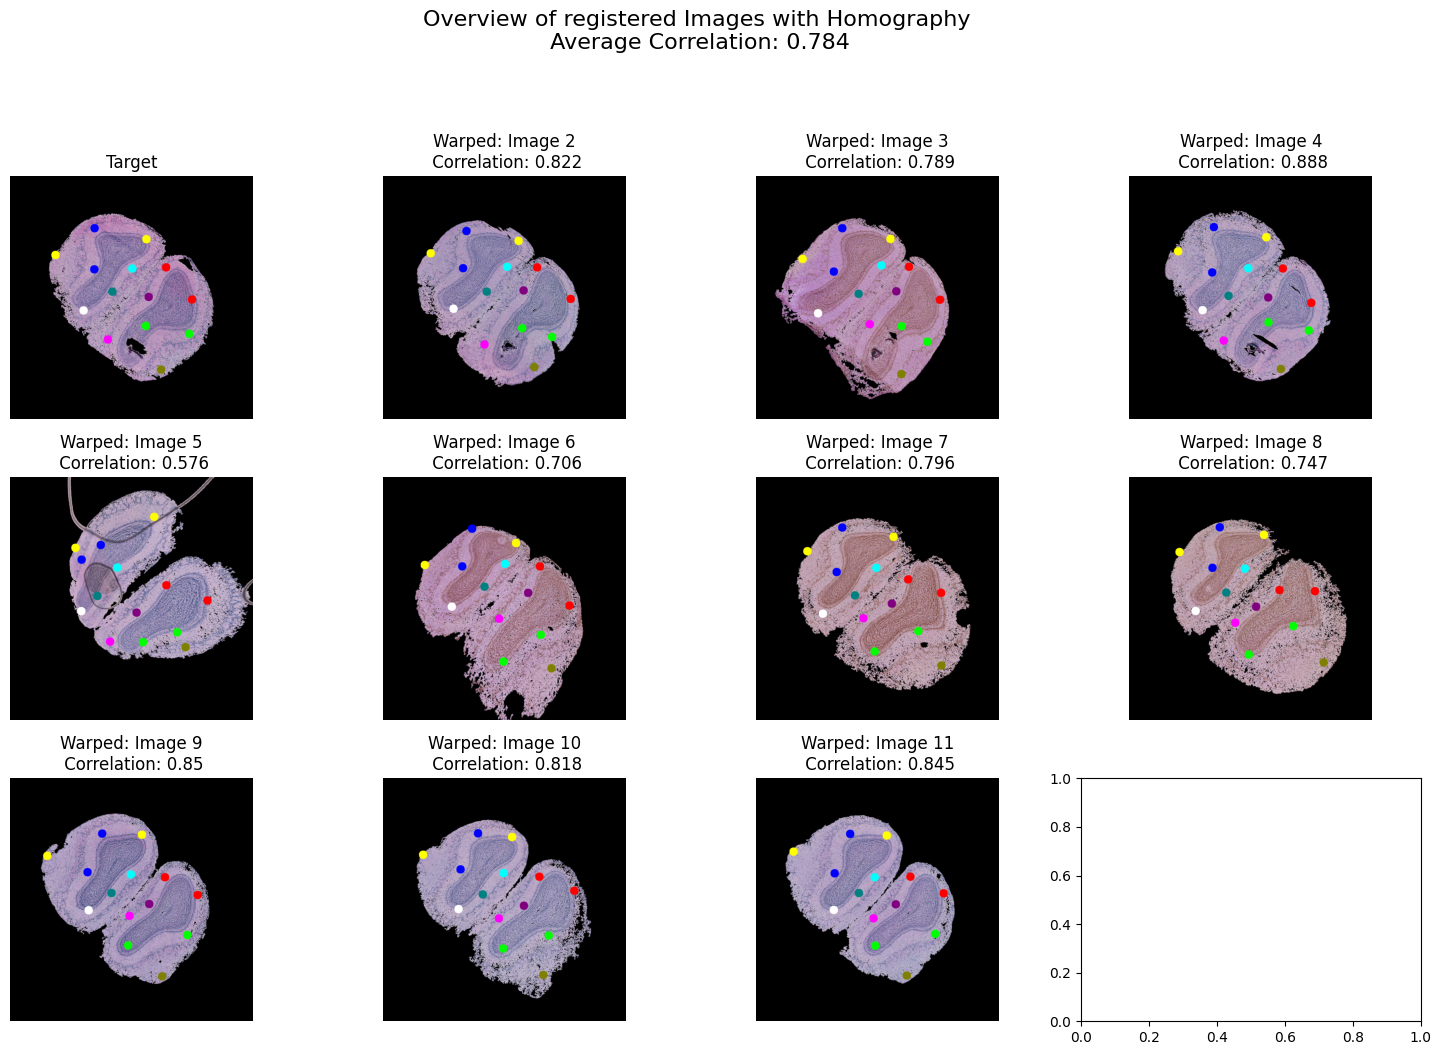

In [23]:
plot_warped_images(mapped_imgs, mapped_pts, homo_loss, 5 * 128, 'Homography')

### Rigid transformation

In [24]:
rigid_transform = Rigid()

In [25]:
#warp images
mapped_imgs = rigid_transform.warp_img(image.cuda(), pts, dst_pts, (863, 863))
#warp landmarks
mapped_pts = rigid_transform.warp_pts(pts, dst_pts, pts)

In [26]:
#rigid_loss = corr(*crop(mapped_imgs, dst_image.cuda())).cpu().numpy()[1:]
rigid_loss = corr(mapped_imgs, dst_image.cuda()).cpu().numpy()[1:]

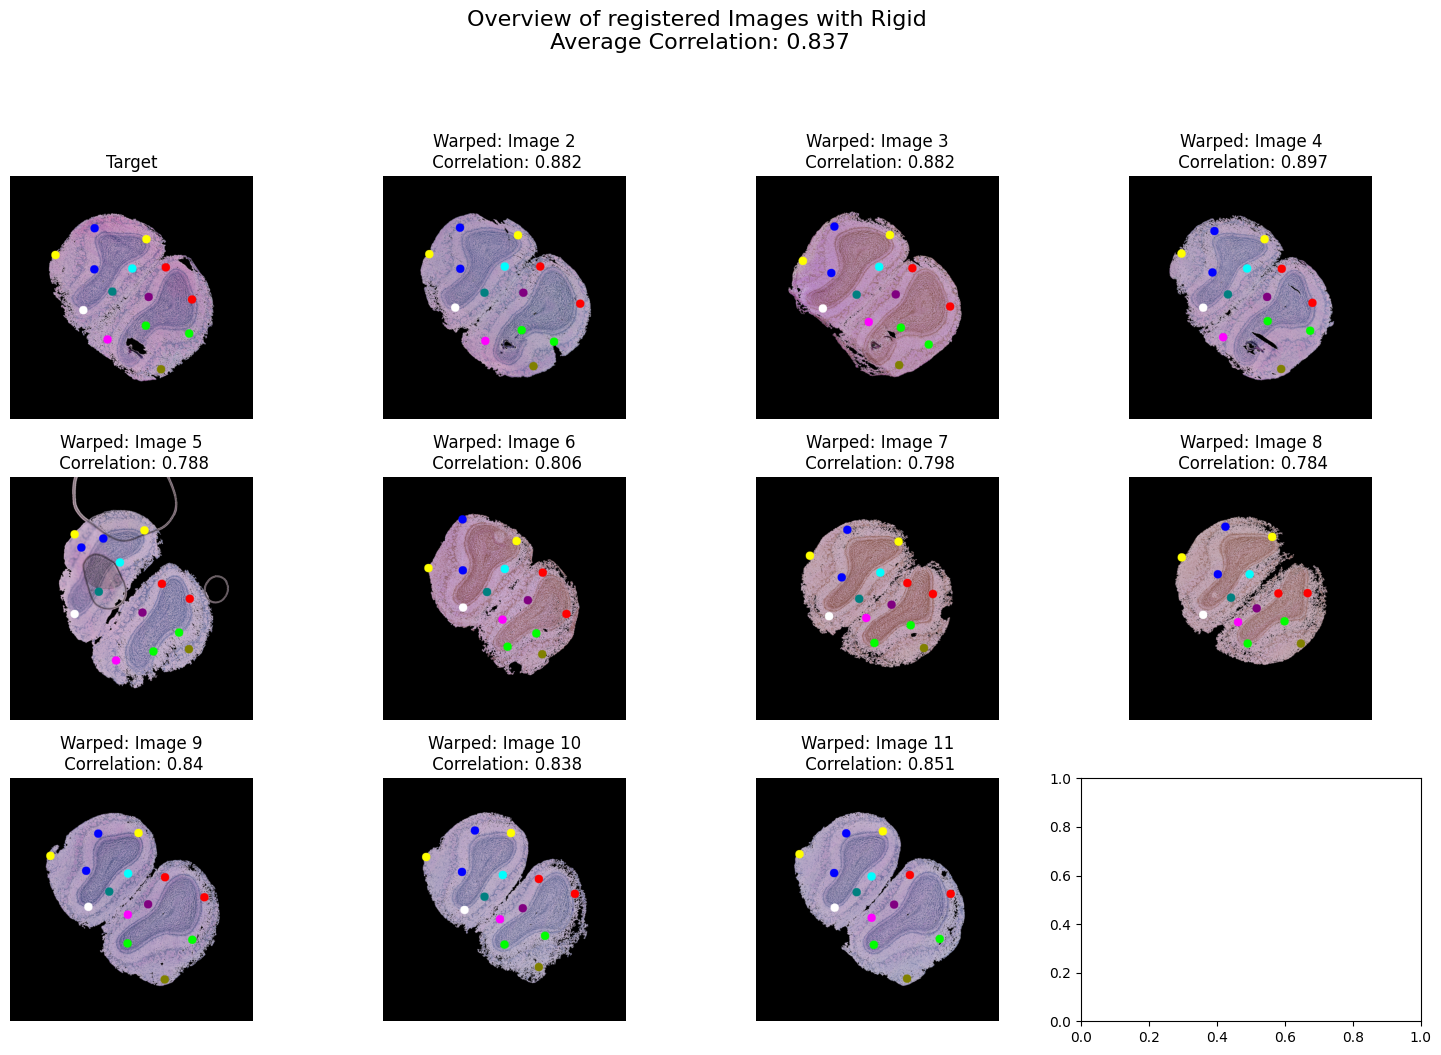

In [27]:
plot_warped_images(mapped_imgs, mapped_pts, rigid_loss, 5 * 128, 'Rigid')

### Affine transform

In [28]:
tps_transform = TPS()

In [29]:
mapped_imgs = tps_transform.warp_img(image.cuda(), pts, dst_pts, reg=1e20, norm=True, size=863)
mapped_pts = tps_transform.warp_pts(pts, dst_pts, pts, reg=1e20)

In [30]:
#affine_loss = corr(*crop(mapped_imgs, dst_image.cuda())).cpu().numpy()[1:]
affine_loss = corr(mapped_imgs, dst_image.cuda()).cpu().numpy()[1:]

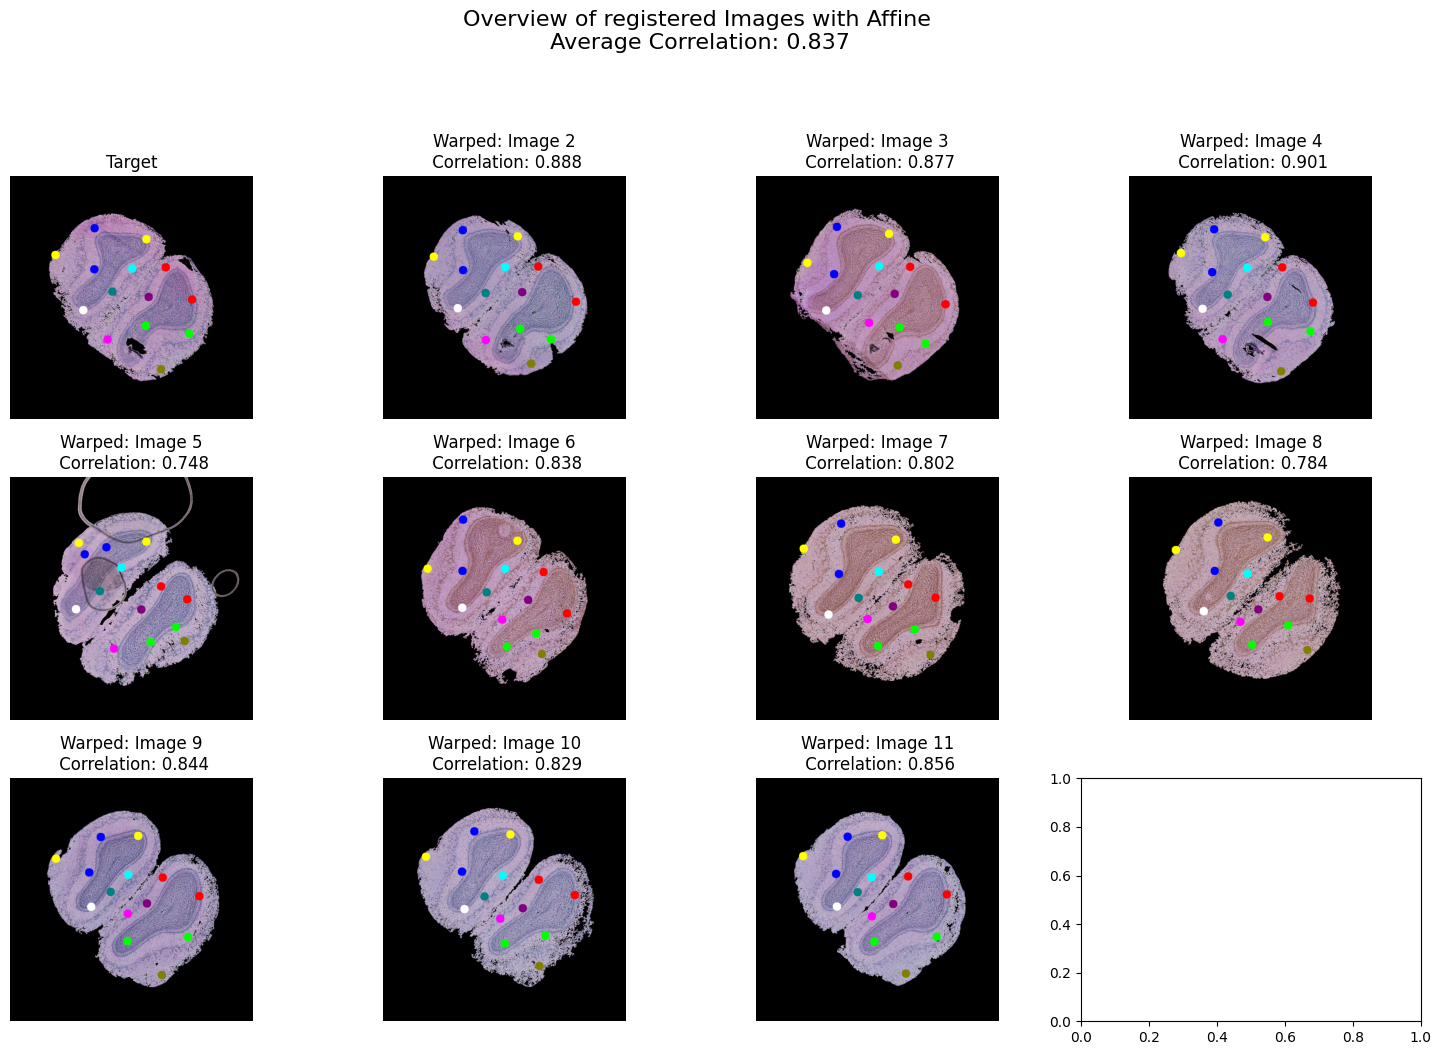

In [31]:
plot_warped_images(mapped_imgs, mapped_pts, affine_loss, 5 * 128, 'Affine')

### Thin-plate splines

In [32]:
mapped_imgs = tps_transform.warp_img(image.cuda(), pts, dst_pts, reg=0, norm=True, size=863)
mapped_pts = tps_transform.warp_pts(pts, dst_pts, pts, reg=0)

In [33]:
#tps_loss = corr(*crop(mapped_imgs, dst_image.cuda())).cpu().numpy()[1:]
tps_loss = corr(mapped_imgs, dst_image.cuda()).cpu().numpy()[1:]

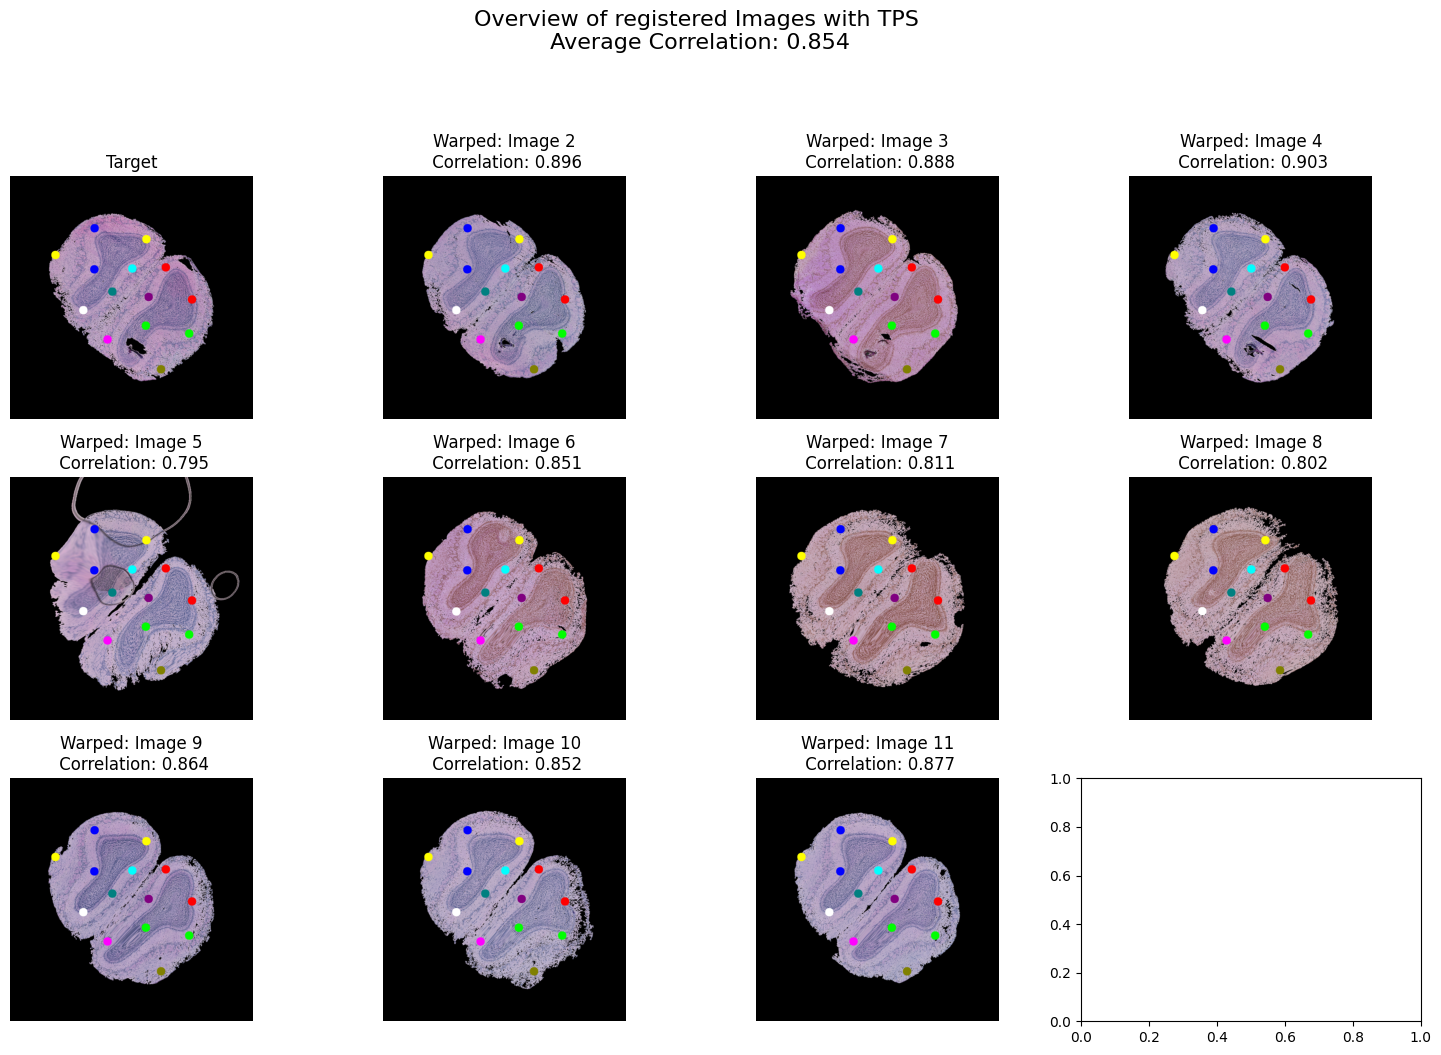

In [34]:
plot_warped_images(mapped_imgs, mapped_pts, tps_loss, 5 * 128, 'TPS')

### Comparision of registration methods

In [35]:
rigid_loss, affine_loss, tps_loss, homo_loss = rigid_loss.tolist(), affine_loss.tolist(), tps_loss.tolist(), homo_loss.tolist()

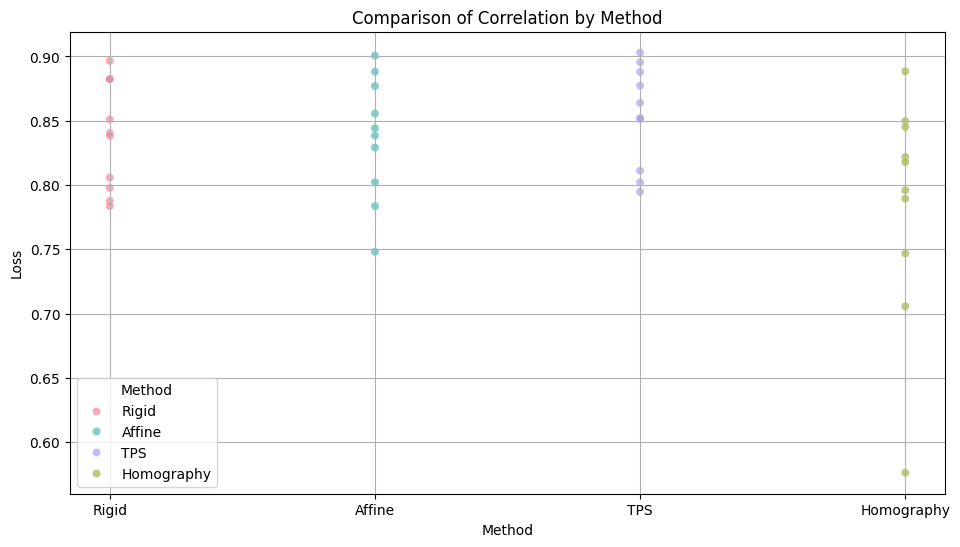

In [36]:
# Combine all loss lists and create a corresponding list of method names
losses = rigid_loss + affine_loss + tps_loss + homo_loss
methods = ['Rigid']*len(rigid_loss) + ['Affine']*len(affine_loss) + ['TPS']*len(tps_loss) + ['Homography']*len(homo_loss)

# Combine all loss lists and create a corresponding list of method names
losses = rigid_loss + affine_loss + tps_loss + homo_loss
methods = ['Rigid']*len(rigid_loss) + ['Affine']*len(affine_loss) + ['TPS']*len(tps_loss) + ['Homography']*len(homo_loss)

# Create a DataFrame
data = pd.DataFrame({'Method': methods, 'Loss': losses})

# Define a custom color palette with unique colors for each method
custom_palette = sns.color_palette("husl", n_colors=len(set(methods)))

# Create a dictionary to map each method to a unique color
method_color_dict = {method: color for method, color in zip(set(methods), custom_palette)}

# Map each method to its corresponding color in the DataFrame
data['Color'] = data['Method'].map(method_color_dict)

# Create a scatter plot using Seaborn with unique colors for each method
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Method', y='Loss', hue='Method', palette=method_color_dict, alpha=0.6)

plt.title('Comparison of Correlation by Method')
plt.xlabel('Method')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(title='Method', loc='lower left')

# Add some space on the right for the legend
plt.subplots_adjust(right=1)


plt.show()